In [38]:
#1 code cell

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from lesson_functions import *
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                           spatial_size=spatial_size, hist_bins=hist_bins, 
                          orient=orient, pix_per_cell=pix_per_cell, 
                           cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                           hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #prob = clf.predict_proba(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
        #if prob[0][0] > 0.8:
            on_windows.append(window)


    #8) Return windows for positive detections
    return on_windows

def convert_color( img, conv  = 'RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    

Number of cars 8792
Number of noncars 8968


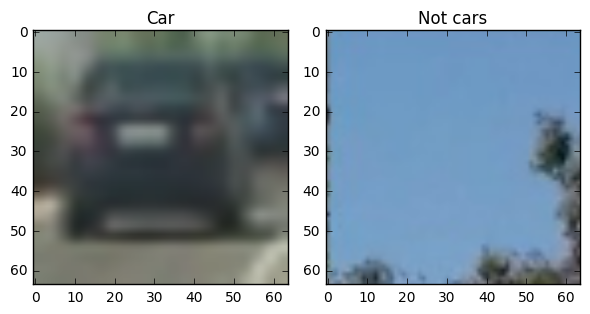

In [3]:
#2nd Code cell
    
# Read in cars and notcars
images = glob.glob('./*/*/*.png')
cars = []
notcars = []
for image in images:
    if 'GTI_non' in image or 'Extras' in image:
        notcars.append(image)
    else:
        cars.append(image)

print('Number of cars',len(cars))
print('Number of noncars',len(notcars))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 1000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
fig = plt.figure()
plt.subplot(121)
plt.imshow(mpimg.imread(cars[0]))
plt.title('Car')
plt.subplot(122)
plt.imshow(mpimg.imread(notcars[0]))
plt.title('Not cars')
fig.tight_layout()
plt.show()





plotting


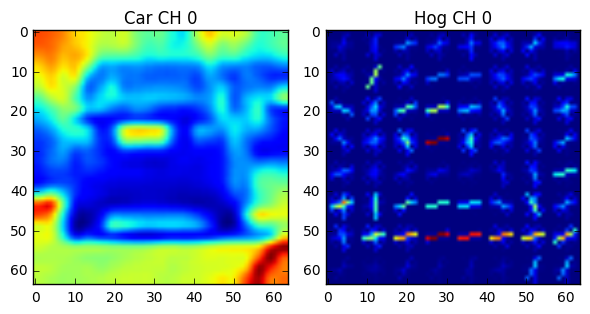

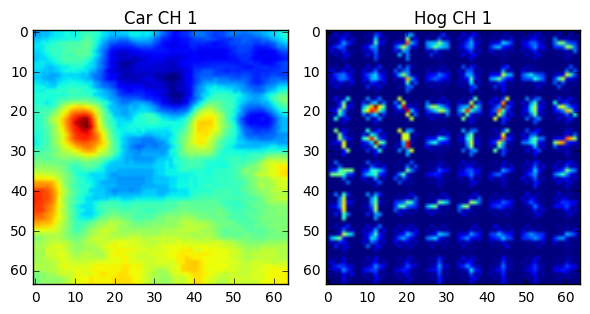

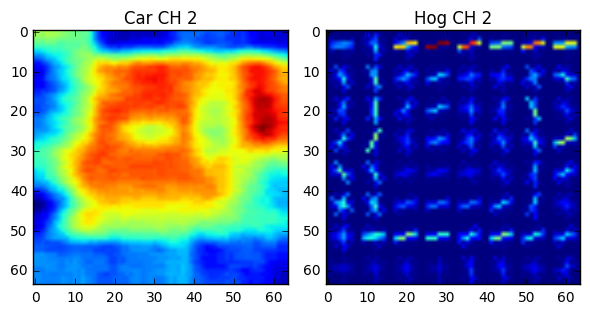

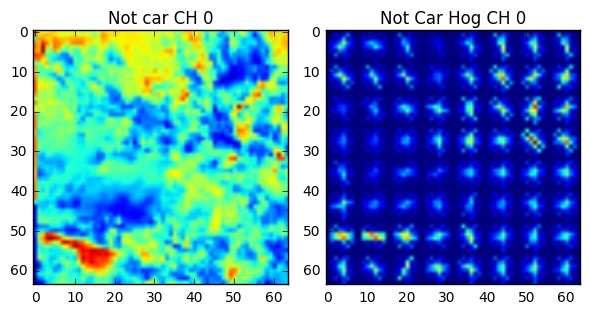

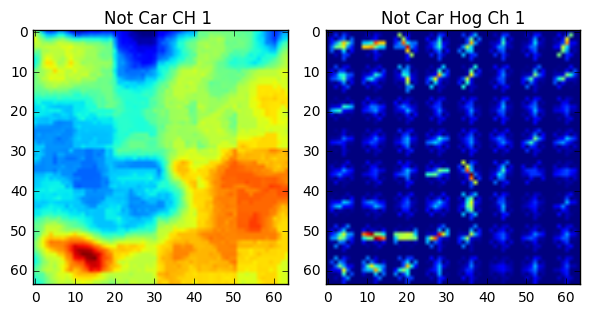

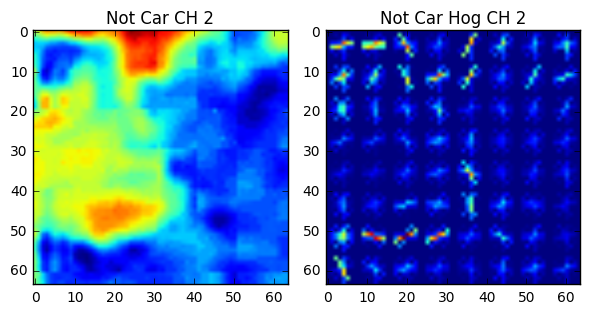

In [24]:
#3 code cell


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32,32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()
print('plotting')


cars_0 = mpimg.imread(cars[0])

not_cars_0 = mpimg.imread(notcars[1])

converted_car = convert_color(cars_0,'RGB2YCrCb')
converted_not_car = convert_color(not_cars_0,'RGB2YCrCb')
features_0,hog_image_0 = get_hog_features(converted_car[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=False)

features_1,hog_image_1 = get_hog_features(converted_car[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=False)


features_2,hog_image_2 = get_hog_features(converted_car[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=False)


  
fig = plt.figure()
plt.subplot(121)
plt.imshow(converted_car[:,:,0])
plt.title('Car CH 0')
plt.subplot(122)
plt.imshow(hog_image_0)
plt.title('Hog CH 0')
fig.tight_layout()
plt.show()

fig = plt.figure()
plt.subplot(121)
plt.imshow(converted_car[:,:,1])

plt.title('Car CH 1')
plt.subplot(122)
plt.imshow(hog_image_1)
plt.title('Hog CH 1')
fig.tight_layout()
plt.show()

fig = plt.figure()
plt.subplot(121)
plt.imshow(converted_car[:,:,2])

plt.title('Car CH 2')
plt.subplot(122)
plt.imshow(hog_image_2)
plt.title('Hog CH 2')
fig.tight_layout()
plt.show()

not_car_features_0,not_car_hog_image_0 = get_hog_features(converted_not_car[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=False)

not_car_features_1,not_car_hog_image_1 = get_hog_features(converted_not_car[:,:,1], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=False)


not_car_features_2,not_car_hog_image_2 = get_hog_features(converted_not_car[:,:,2], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=False)


fig = plt.figure()
plt.subplot(121)
plt.imshow(converted_not_car[:,:,0])
plt.title('Not car CH 0')
plt.subplot(122)
plt.imshow(not_car_hog_image_0)
plt.title('Not Car Hog CH 0')
fig.tight_layout()
plt.show()

fig = plt.figure()
plt.subplot(121)
plt.imshow(converted_not_car[:,:,1])

plt.title('Not Car CH 1 ')
plt.subplot(122)
plt.imshow(not_car_hog_image_1)
plt.title('Not Car Hog Ch 1')
fig.tight_layout()
plt.show()

fig = plt.figure()
plt.subplot(121)
plt.imshow(converted_not_car[:,:,2])

plt.title('Not Car CH 2')
plt.subplot(122)
plt.imshow(not_car_hog_image_2)
plt.title('Not Car Hog CH 2')
fig.tight_layout()
plt.show()


In [26]:
#4 code cell

print ('training')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))





# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

X_train, y_train = shuffle(X_train, y_train)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

training
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
30.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


In [34]:
#5th code cell

    from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    print (labels)
    bboxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img, bboxes



In [35]:
#6th code cell
bboxes_over_frame = []


def find_labeled_box(img, labels):
    print (labels)
    bboxes = []
    # Iterate through all detected cars
    newbbox = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bboxes.append(bbox)
        # Draw the box on the image
    # Return the image
    prev_bboxes  = []
    if len(bboxes_over_frame) > 0:
        prev_bboxes = bboxes_over_frame[-1]
    if len(prev_bboxes) > 0:
        for bbox in bboxes:
            if (check_prev_frame(prev_bboxes,bbox)):
                    cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            newbbox.append(bbox)

    else:
         for bbox in bboxes:
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)  
                newbbox.append(bbox)

    bboxes_over_frame.append(newbbox)

    return  img

def check_prev_frame(prev_bboxes,bbox ):
    for prev_bbox in prev_bboxes:
                if (prev_bbox[0][0]-300 < bbox[0][0] and prev_bbox[0][0]+300 > bbox[0][0] ):
                     return True
    return False

            


image name : ./test_images/test1.jpg
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


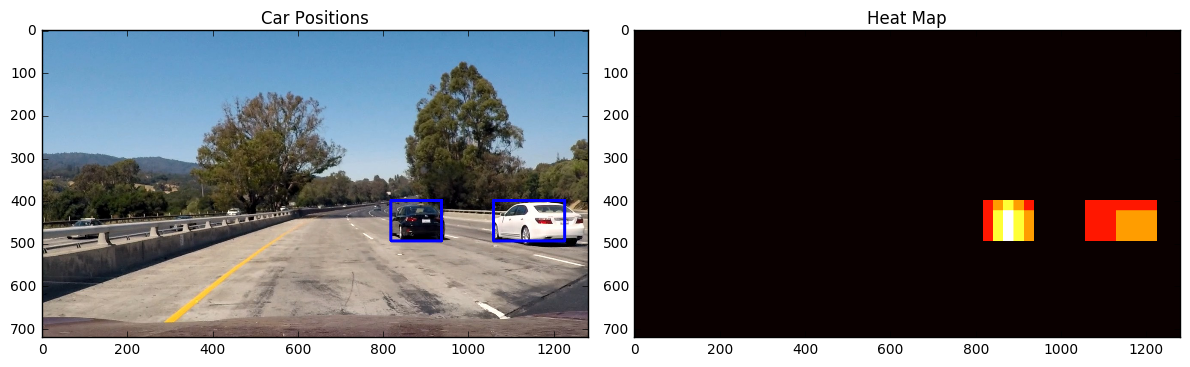

image name : ./test_images/test2.jpg
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)


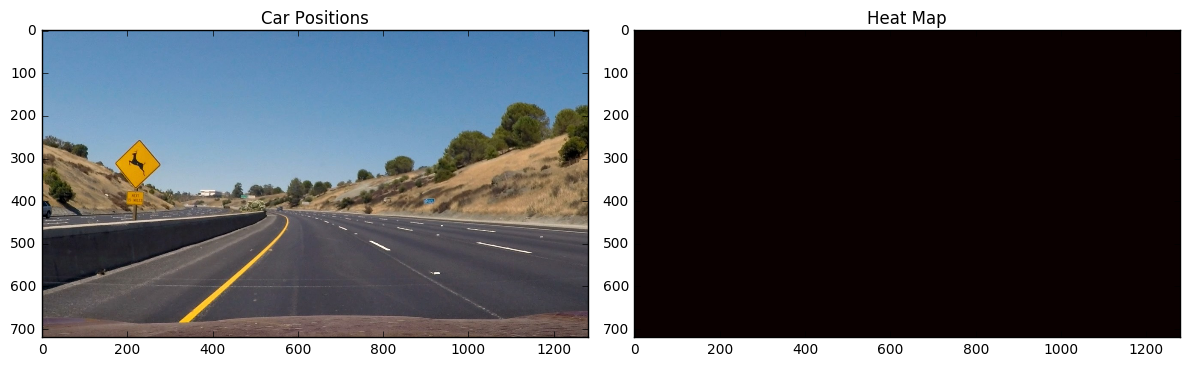

image name : ./test_images/test3.jpg
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


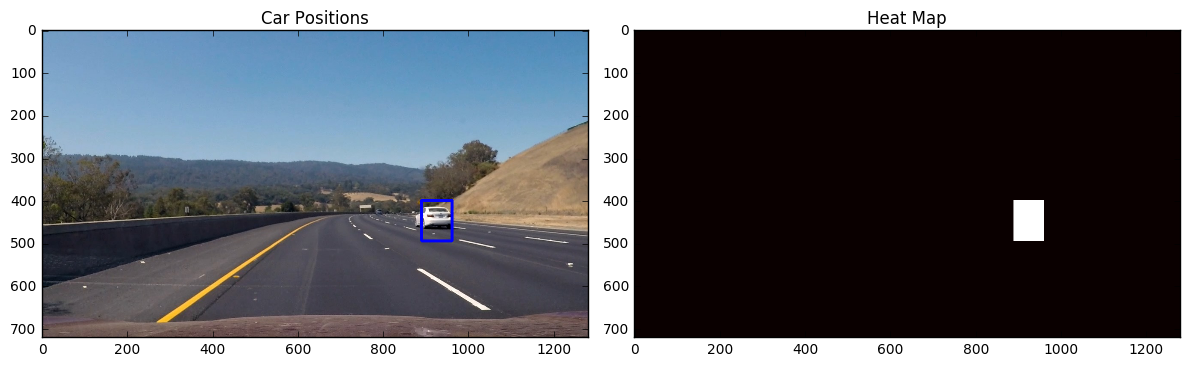

image name : ./test_images/test4.jpg
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


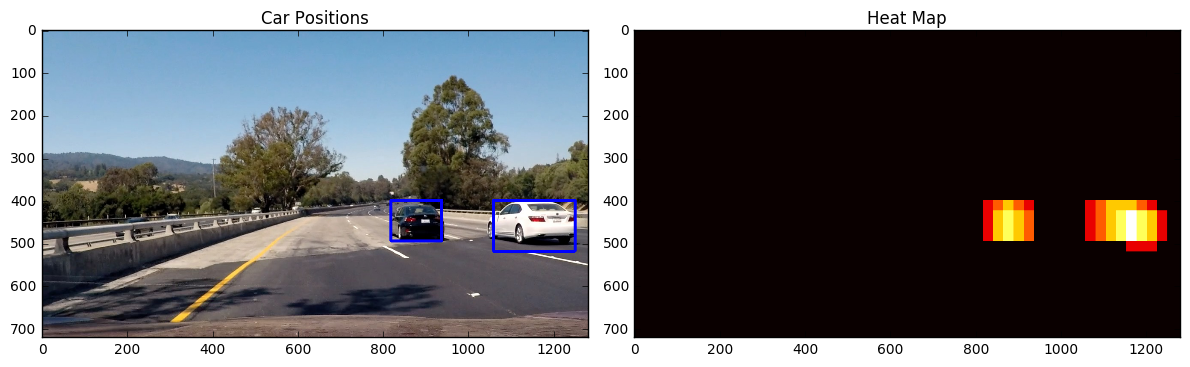

image name : ./test_images/test5.jpg
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


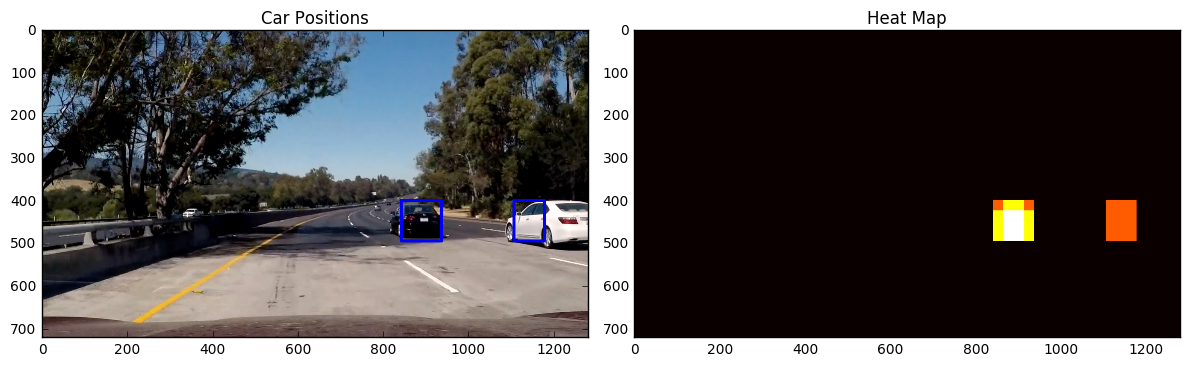

image name : ./test_images/test6.jpg
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


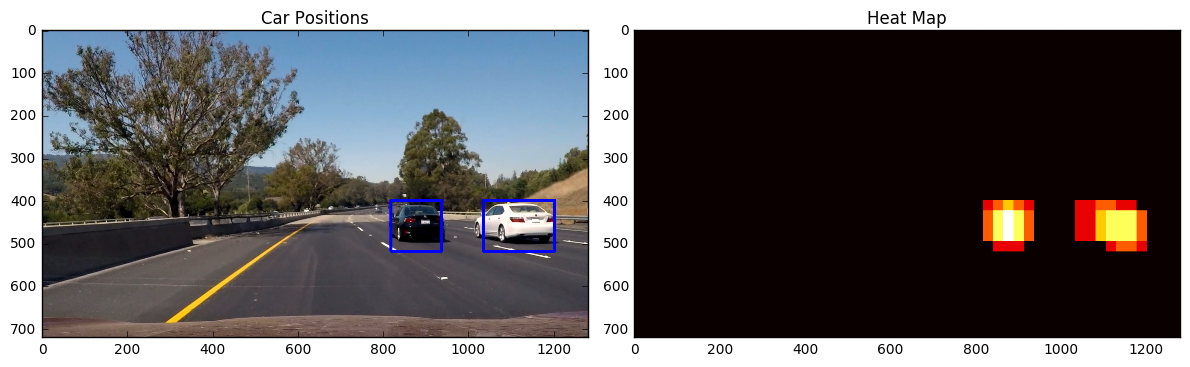

In [53]:
#7th code cell
out_images = []
out_maps = []
out_titles = []
out_boxes = []


ystart = 400
ystop  = 656
scale = 1.5
images = glob.glob('./test_images/*')
for image in images:
    print('image name :', image)
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(image)
    draw_img = np.copy(img)
    heat_map = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        print (imshape)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, ((np.int(imshape[1]/scale)),(np.int(imshape[0]/scale))))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    print (ch1.shape)
    nxblocks = (ch1.shape[1]//pix_per_cell) - 1
    nyblocks = (ch1.shape[0]//pix_per_cell) - 1
    
    print ('nxblocks',nxblocks,'nyblocks',nyblocks)
    
    nfeat_per_block = orient * cell_per_block ** 2
    print ('orient ', orient,'cell_per_block',cell_per_block,'pix_per_cell',pix_per_cell )
    window = 64
    
    nblocks_per_window = (window/pix_per_cell) - 1
    print ('nblocks_per_window',nblocks_per_window)
    
    
    cells_per_step = 2
    
    nxsteps = np.int((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = np.int((nyblocks - nblocks_per_window) // cells_per_step)
    
    print ('nxsteps',nxsteps,'nysteps',nysteps)
    
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec= False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec= False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec= False)

    heatmap = []
    new_img = np.copy(img)


    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()

            hog_features = np.hstack((hog_feat1, hog_feat2,hog_feat3))
            #if np.any(np.isnan(hog_features)):
             #   print ('all')           



            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))
            
            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)
            
            stack_features = np.hstack((spatial_features,hist_features, hog_features ))
            
              


            #print ('stack',stack_features)
            
            
            test_features = X_scaler.transform(stack_features).reshape(1,-1)
            
            
             #6) Predict using your classifier
            prediction = svc.predict(test_features)
       
       
            #prob = clf.predict_proba(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                print ('pred',prediction)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int( ytop *scale)
                win_draw = np.int(window*scale)
                cv2.rectangle( new_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart ), (0,0,255), 6)
                
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart )))

                heat_map[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
                
                
    heat = apply_threshold(heat_map,1)




    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    
    draw_image = find_labeled_box(np.copy(draw_img), labels)
    #draw_image,bboxes = draw_labeled_bboxes(np.copy(draw_img), labels)
    bboxes_over_frame = []


    #print (bboxes)


  
    fig  = plt.figure( figsize=(12,24))
    plt.subplot(121)
    plt.imshow(draw_image)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

   
        

    
    
    



In [40]:
#8th code cell
out_images = []
out_maps = []
out_titles = []
out_boxes = []

def process_video(img):
    ystart = 400
    ystop  = 656
    scale = 1.5
    img_boxes = []
    t = time.time()
    count = 0
    draw_img = np.copy(img)
    heat_map = np.zeros_like(img[:,:,0])
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        print (imshape)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, ((np.int(imshape[1]/scale)),(np.int(imshape[0]/scale))))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    print (ch1.shape)
    nxblocks = (ch1.shape[1]//pix_per_cell) - 1
    nyblocks = (ch1.shape[0]//pix_per_cell) - 1

    print ('nxblocks',nxblocks,'nyblocks',nyblocks)

    nfeat_per_block = orient * cell_per_block ** 2
    print ('orient ', orient,'cell_per_block',cell_per_block,'pix_per_cell',pix_per_cell )
    window = 64

    nblocks_per_window = (window/pix_per_cell) - 1
    print ('nblocks_per_window',nblocks_per_window)


    cells_per_step = 2

    nxsteps = np.int((nxblocks - nblocks_per_window) // cells_per_step)
    nysteps = np.int((nyblocks - nblocks_per_window) // cells_per_step)

    print ('nxsteps',nxsteps,'nysteps',nysteps)

    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec= False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec= False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec= False)

    heatmap = []

    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step

            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,xpos:xpos+nblocks_per_window].ravel()

            hog_features = np.hstack((hog_feat1, hog_feat2,hog_feat3))
            #if np.any(np.isnan(hog_features)):
             #   print ('all')           



            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))

            spatial_features = bin_spatial(subimg, size = spatial_size)
            hist_features = color_hist(subimg, nbins = hist_bins)

            stack_features = np.hstack((spatial_features,hist_features, hog_features ))



            #print ('stack',stack_features)


            test_features = X_scaler.transform(stack_features).reshape(1,-1)


             #6) Predict using your classifier
            prediction = svc.predict(test_features)

            #prob = clf.predict_proba(test_features)
            #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                print ('pred',prediction)
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int( ytop *scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle( draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart ), (0,0,255), 6)

                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart )))

                heat_map[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1


    heat = apply_threshold(heat_map,1)




    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_image = find_labeled_box(np.copy(draw_img), labels)

    return draw_image

   
     

In [41]:
#9th code cell
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from multiprocessing import pool

#p = pool.Pool()
challenge_output = 'project_final_4.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video) 

white_clip.write_videofile(challenge_output, audio=False)




(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
[MoviePy] >>>> Building video project_final_4.mp4
[MoviePy] Writing video project_final_4.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  0%|          | 1/1261 [00:00<07:18,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  0%|          | 2/1261 [00:00<07:30,  2.79it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  0%|          | 3/1261 [00:01<08:20,  2.51it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  0%|          | 4/1261 [00:01<08:34,  2.44it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  0%|          | 5/1261 [00:01<08:05,  2.59it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  0%|          | 6/1261 [00:02<07:50,  2.67it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 7/1261 [00:02<08:01,  2.61it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 8/1261 [00:03<08:11,  2.55it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 9/1261 [00:03<07:49,  2.67it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 10/1261 [00:03<07:40,  2.72it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 11/1261 [00:04<07:26,  2.80it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 12/1261 [00:04<07:15,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 13/1261 [00:04<07:05,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 14/1261 [00:05<07:01,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|          | 15/1261 [00:05<06:58,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|▏         | 16/1261 [00:05<06:54,  3.01it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|▏         | 17/1261 [00:06<06:53,  3.01it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  1%|▏         | 18/1261 [00:06<06:50,  3.03it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 19/1261 [00:06<06:50,  3.02it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 20/1261 [00:07<06:49,  3.03it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 21/1261 [00:07<06:48,  3.04it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 22/1261 [00:07<06:49,  3.03it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 23/1261 [00:08<06:46,  3.05it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 24/1261 [00:08<06:44,  3.06it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 25/1261 [00:08<06:41,  3.08it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 26/1261 [00:09<06:41,  3.07it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 27/1261 [00:09<06:41,  3.07it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 28/1261 [00:09<06:40,  3.08it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 29/1261 [00:10<06:40,  3.08it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 30/1261 [00:10<06:40,  3.07it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  2%|▏         | 31/1261 [00:10<06:38,  3.09it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 32/1261 [00:11<06:38,  3.08it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 33/1261 [00:11<06:37,  3.09it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 34/1261 [00:11<06:39,  3.07it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 35/1261 [00:12<06:38,  3.08it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 36/1261 [00:12<06:40,  3.06it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 37/1261 [00:12<06:41,  3.05it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 38/1261 [00:12<06:41,  3.05it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 39/1261 [00:13<06:41,  3.04it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 40/1261 [00:13<06:40,  3.05it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 41/1261 [00:13<06:39,  3.06it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 42/1261 [00:14<06:43,  3.02it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 43/1261 [00:14<06:56,  2.92it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  3%|▎         | 44/1261 [00:15<06:51,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▎         | 45/1261 [00:15<06:47,  2.99it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▎         | 46/1261 [00:15<06:43,  3.01it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▎         | 47/1261 [00:15<06:42,  3.01it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 48/1261 [00:16<06:45,  2.99it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 49/1261 [00:16<06:48,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 50/1261 [00:17<07:08,  2.83it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 51/1261 [00:17<07:01,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 52/1261 [00:17<06:54,  2.92it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 53/1261 [00:18<06:52,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 54/1261 [00:18<06:51,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 55/1261 [00:18<06:48,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  4%|▍         | 56/1261 [00:19<06:49,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 57/1261 [00:19<06:48,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 58/1261 [00:19<06:52,  2.92it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 59/1261 [00:20<06:52,  2.92it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 60/1261 [00:20<06:49,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 61/1261 [00:20<06:47,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 62/1261 [00:21<06:48,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▍         | 63/1261 [00:21<06:46,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▌         | 64/1261 [00:21<06:44,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▌         | 65/1261 [00:22<06:47,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▌         | 66/1261 [00:22<06:44,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▌         | 67/1261 [00:22<06:41,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▌         | 68/1261 [00:23<06:43,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  5%|▌         | 69/1261 [00:23<06:46,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 70/1261 [00:23<06:41,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 71/1261 [00:24<06:39,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 72/1261 [00:24<06:37,  2.99it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 73/1261 [00:24<06:35,  3.00it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 74/1261 [00:25<06:36,  2.99it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 75/1261 [00:25<06:36,  2.99it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 76/1261 [00:25<06:34,  3.00it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 77/1261 [00:26<06:37,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▌         | 78/1261 [00:26<06:37,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▋         | 79/1261 [00:26<06:37,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▋         | 80/1261 [00:27<06:37,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  6%|▋         | 81/1261 [00:27<06:34,  2.99it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 82/1261 [00:27<06:36,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 83/1261 [00:28<06:35,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 84/1261 [00:28<06:35,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 85/1261 [00:28<06:32,  3.00it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 86/1261 [00:29<06:31,  3.00it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 87/1261 [00:29<06:38,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 88/1261 [00:29<06:40,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 89/1261 [00:30<06:40,  2.92it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 90/1261 [00:30<06:39,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 91/1261 [00:30<06:37,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 92/1261 [00:31<06:37,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 93/1261 [00:31<06:34,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  7%|▋         | 94/1261 [00:31<06:33,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 95/1261 [00:32<06:40,  2.91it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 96/1261 [00:32<06:38,  2.92it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 97/1261 [00:32<06:45,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 98/1261 [00:33<06:46,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 99/1261 [00:33<06:45,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 100/1261 [00:34<06:43,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 101/1261 [00:34<06:42,  2.88it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 102/1261 [00:34<06:44,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 103/1261 [00:35<06:47,  2.84it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 104/1261 [00:35<06:49,  2.83it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 105/1261 [00:35<06:45,  2.85it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 106/1261 [00:36<06:42,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  8%|▊         | 107/1261 [00:36<06:43,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▊         | 108/1261 [00:36<07:00,  2.74it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▊         | 109/1261 [00:37<07:53,  2.43it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▊         | 110/1261 [00:37<07:36,  2.52it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 111/1261 [00:38<07:19,  2.62it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 112/1261 [00:38<07:05,  2.70it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 113/1261 [00:38<06:57,  2.75it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 114/1261 [00:39<07:28,  2.55it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 115/1261 [00:39<07:20,  2.60it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 116/1261 [00:39<07:07,  2.68it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 117/1261 [00:40<06:58,  2.74it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 118/1261 [00:40<06:49,  2.79it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


  9%|▉         | 119/1261 [00:41<06:56,  2.74it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 120/1261 [00:41<07:23,  2.57it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 121/1261 [00:41<07:24,  2.56it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 122/1261 [00:42<07:12,  2.63it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 123/1261 [00:42<06:57,  2.73it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 124/1261 [00:42<06:48,  2.78it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 125/1261 [00:43<06:50,  2.77it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|▉         | 126/1261 [00:43<06:45,  2.80it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|█         | 127/1261 [00:43<06:41,  2.82it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|█         | 128/1261 [00:44<06:37,  2.85it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|█         | 129/1261 [00:44<06:35,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|█         | 130/1261 [00:45<06:37,  2.85it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|█         | 131/1261 [00:45<06:36,  2.85it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 10%|█         | 132/1261 [00:45<06:36,  2.85it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█         | 133/1261 [00:46<06:36,  2.84it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█         | 134/1261 [00:46<06:37,  2.83it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█         | 135/1261 [00:46<06:34,  2.85it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 11%|█         | 136/1261 [00:47<06:35,  2.84it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 11%|█         | 137/1261 [00:47<06:35,  2.84it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 11%|█         | 138/1261 [00:47<06:37,  2.83it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█         | 139/1261 [00:48<06:32,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█         | 140/1261 [00:48<06:30,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█         | 141/1261 [00:48<06:27,  2.89it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█▏        | 142/1261 [00:49<06:27,  2.89it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█▏        | 143/1261 [00:49<06:26,  2.89it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█▏        | 144/1261 [00:49<06:27,  2.88it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 11%|█▏        | 145/1261 [00:50<06:29,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 146/1261 [00:50<06:27,  2.87it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 147/1261 [00:50<06:29,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 148/1261 [00:51<06:26,  2.88it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 149/1261 [00:51<06:25,  2.89it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 150/1261 [00:51<06:24,  2.89it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 151/1261 [00:52<06:27,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 152/1261 [00:52<06:27,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 153/1261 [00:53<06:26,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 154/1261 [00:53<06:22,  2.90it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 155/1261 [00:53<06:21,  2.90it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 156/1261 [00:54<06:19,  2.91it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 12%|█▏        | 157/1261 [00:54<06:23,  2.88it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 158/1261 [00:54<06:28,  2.84it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 159/1261 [00:55<06:25,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 160/1261 [00:55<06:24,  2.86it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 161/1261 [00:55<06:22,  2.88it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 162/1261 [00:56<06:22,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 163/1261 [00:56<06:33,  2.79it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 164/1261 [00:56<06:30,  2.81it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 165/1261 [00:57<06:28,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 166/1261 [00:57<06:30,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 167/1261 [00:57<06:27,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 168/1261 [00:58<06:28,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 169/1261 [00:58<06:30,  2.80it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 13%|█▎        | 170/1261 [00:59<06:28,  2.81it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▎        | 171/1261 [00:59<06:25,  2.82it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▎        | 172/1261 [00:59<06:26,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▎        | 173/1261 [01:00<06:32,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 174/1261 [01:00<06:34,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 175/1261 [01:00<06:33,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 176/1261 [01:01<06:34,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 177/1261 [01:01<06:30,  2.78it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 178/1261 [01:01<06:27,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 179/1261 [01:02<06:30,  2.77it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 180/1261 [01:02<06:37,  2.72it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 181/1261 [01:03<06:28,  2.78it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 14%|█▍        | 182/1261 [01:03<06:20,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 183/1261 [01:03<06:19,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 184/1261 [01:04<06:18,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 185/1261 [01:04<06:17,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 186/1261 [01:04<06:20,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 187/1261 [01:05<06:24,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 188/1261 [01:05<06:27,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▍        | 189/1261 [01:05<06:24,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▌        | 190/1261 [01:06<06:21,  2.81it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▌        | 191/1261 [01:06<06:20,  2.81it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▌        | 192/1261 [01:06<06:21,  2.80it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▌        | 193/1261 [01:07<06:20,  2.81it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▌        | 194/1261 [01:07<06:22,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 15%|█▌        | 195/1261 [01:07<06:23,  2.78it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 196/1261 [01:08<06:19,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 197/1261 [01:08<06:15,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 198/1261 [01:09<06:14,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 199/1261 [01:09<06:12,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 200/1261 [01:09<06:12,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 201/1261 [01:10<06:13,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 202/1261 [01:10<06:13,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 203/1261 [01:10<06:11,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▌        | 204/1261 [01:11<06:10,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▋        | 205/1261 [01:11<06:06,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▋        | 206/1261 [01:11<06:06,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▋        | 207/1261 [01:12<06:08,  2.86it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 16%|█▋        | 208/1261 [01:12<06:05,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 209/1261 [01:12<06:02,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 210/1261 [01:13<06:01,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 211/1261 [01:13<05:58,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 212/1261 [01:13<05:57,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 213/1261 [01:14<05:55,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 214/1261 [01:14<05:58,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 215/1261 [01:14<05:57,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 216/1261 [01:15<06:00,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 217/1261 [01:15<05:58,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 218/1261 [01:15<06:00,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 219/1261 [01:16<05:58,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 17%|█▋        | 220/1261 [01:16<06:00,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 221/1261 [01:16<05:59,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 222/1261 [01:17<05:59,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 223/1261 [01:17<05:57,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 224/1261 [01:18<05:59,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 225/1261 [01:18<06:04,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 226/1261 [01:18<06:03,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 227/1261 [01:19<06:03,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 228/1261 [01:19<06:02,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 229/1261 [01:19<06:00,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 230/1261 [01:20<06:00,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 231/1261 [01:20<05:57,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 232/1261 [01:20<05:54,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 18%|█▊        | 233/1261 [01:21<05:57,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▊        | 234/1261 [01:21<05:54,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▊        | 235/1261 [01:21<05:54,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▊        | 236/1261 [01:22<05:52,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 19%|█▉        | 237/1261 [01:22<05:52,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▉        | 238/1261 [01:22<05:50,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▉        | 239/1261 [01:23<05:50,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▉        | 240/1261 [01:23<05:54,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▉        | 241/1261 [01:23<05:55,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 19%|█▉        | 242/1261 [01:24<05:53,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 19%|█▉        | 243/1261 [01:24<05:50,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 19%|█▉        | 244/1261 [01:24<05:50,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 19%|█▉        | 245/1261 [01:25<05:50,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 246/1261 [01:25<05:48,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 247/1261 [01:25<05:47,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 248/1261 [01:26<05:45,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 249/1261 [01:26<05:46,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 250/1261 [01:27<05:45,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 251/1261 [01:27<05:45,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|█▉        | 252/1261 [01:27<05:45,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|██        | 253/1261 [01:28<05:45,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|██        | 254/1261 [01:28<05:47,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|██        | 255/1261 [01:28<05:51,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|██        | 256/1261 [01:29<05:55,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|██        | 257/1261 [01:29<05:52,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 20%|██        | 258/1261 [01:29<05:49,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 259/1261 [01:30<05:52,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 260/1261 [01:30<05:49,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 261/1261 [01:30<05:45,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 262/1261 [01:31<05:45,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 263/1261 [01:31<05:42,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 264/1261 [01:31<05:42,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 265/1261 [01:32<05:44,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 266/1261 [01:32<05:45,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██        | 267/1261 [01:32<05:45,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██▏       | 268/1261 [01:33<05:45,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██▏       | 269/1261 [01:33<05:44,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██▏       | 270/1261 [01:33<05:44,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 21%|██▏       | 271/1261 [01:34<05:46,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 272/1261 [01:34<05:41,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 273/1261 [01:34<05:38,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 274/1261 [01:35<05:38,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 275/1261 [01:35<05:36,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 276/1261 [01:36<05:36,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 277/1261 [01:36<05:35,  2.94it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 278/1261 [01:36<05:37,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 279/1261 [01:37<05:35,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 280/1261 [01:37<05:33,  2.94it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 281/1261 [01:37<05:33,  2.94it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 282/1261 [01:38<05:34,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 22%|██▏       | 283/1261 [01:38<05:34,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 284/1261 [01:38<05:34,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 285/1261 [01:39<05:34,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 286/1261 [01:39<05:35,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 287/1261 [01:39<05:34,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 288/1261 [01:40<05:36,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 289/1261 [01:40<05:37,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 290/1261 [01:40<05:41,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 23%|██▎       | 291/1261 [01:41<06:16,  2.57it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 292/1261 [01:41<06:24,  2.52it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 293/1261 [01:42<06:18,  2.56it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 294/1261 [01:42<06:11,  2.60it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 295/1261 [01:42<06:02,  2.66it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 23%|██▎       | 296/1261 [01:43<06:12,  2.59it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▎       | 297/1261 [01:43<06:18,  2.55it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▎       | 298/1261 [01:44<06:12,  2.59it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▎       | 299/1261 [01:44<06:33,  2.44it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 300/1261 [01:44<06:35,  2.43it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 301/1261 [01:45<06:20,  2.52it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 302/1261 [01:45<06:11,  2.58it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 303/1261 [01:45<06:03,  2.64it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 304/1261 [01:46<05:52,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 305/1261 [01:46<05:45,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 306/1261 [01:47<05:46,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


 24%|██▍       | 307/1261 [01:47<05:47,  2.75it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 24%|██▍       | 308/1261 [01:47<05:47,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 309/1261 [01:48<05:42,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 310/1261 [01:48<05:38,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 311/1261 [01:48<05:35,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 312/1261 [01:49<05:31,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 313/1261 [01:49<05:29,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 314/1261 [01:49<05:28,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▍       | 315/1261 [01:50<05:27,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▌       | 316/1261 [01:50<05:26,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▌       | 317/1261 [01:50<05:25,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▌       | 318/1261 [01:51<05:25,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▌       | 319/1261 [01:51<05:25,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▌       | 320/1261 [01:51<05:25,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 25%|██▌       | 321/1261 [01:52<05:27,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 322/1261 [01:52<05:29,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 323/1261 [01:52<05:27,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 324/1261 [01:53<05:26,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 325/1261 [01:53<05:24,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 326/1261 [01:54<05:22,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 327/1261 [01:54<05:22,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 328/1261 [01:54<05:26,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 329/1261 [01:55<05:23,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 330/1261 [01:55<05:21,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▌       | 331/1261 [01:55<05:20,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▋       | 332/1261 [01:56<05:18,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 26%|██▋       | 333/1261 [01:56<05:17,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 26%|██▋       | 334/1261 [01:56<05:18,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 27%|██▋       | 335/1261 [01:57<05:17,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 27%|██▋       | 336/1261 [01:57<05:19,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 337/1261 [01:57<05:19,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 338/1261 [01:58<05:18,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 339/1261 [01:58<05:17,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 340/1261 [01:58<05:16,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 341/1261 [01:59<05:14,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 342/1261 [01:59<05:15,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 343/1261 [01:59<05:14,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 344/1261 [02:00<05:16,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 345/1261 [02:00<05:17,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 27%|██▋       | 346/1261 [02:00<05:17,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 347/1261 [02:01<05:17,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 348/1261 [02:01<05:18,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 349/1261 [02:01<05:17,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 350/1261 [02:02<05:17,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 351/1261 [02:02<05:20,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 352/1261 [02:03<05:17,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 353/1261 [02:03<05:17,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 354/1261 [02:03<05:15,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 355/1261 [02:04<05:13,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 356/1261 [02:04<05:13,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 357/1261 [02:04<05:12,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 28%|██▊       | 358/1261 [02:05<05:13,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 28%|██▊       | 359/1261 [02:05<05:13,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▊       | 360/1261 [02:05<05:11,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▊       | 361/1261 [02:06<05:09,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▊       | 362/1261 [02:06<05:09,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 363/1261 [02:06<05:08,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 364/1261 [02:07<05:08,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 365/1261 [02:07<05:09,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 366/1261 [02:07<05:11,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 367/1261 [02:08<05:11,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 368/1261 [02:08<05:12,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 369/1261 [02:08<05:09,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 370/1261 [02:09<05:08,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 29%|██▉       | 371/1261 [02:09<05:07,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 372/1261 [02:09<05:08,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 373/1261 [02:10<05:06,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 374/1261 [02:10<05:06,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 375/1261 [02:10<05:05,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 376/1261 [02:11<05:04,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 377/1261 [02:11<05:04,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|██▉       | 378/1261 [02:11<05:05,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|███       | 379/1261 [02:12<05:05,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|███       | 380/1261 [02:12<05:06,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|███       | 381/1261 [02:13<05:03,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|███       | 382/1261 [02:13<05:04,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|███       | 383/1261 [02:13<05:01,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 30%|███       | 384/1261 [02:14<05:01,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 385/1261 [02:14<05:01,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 386/1261 [02:14<05:00,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 387/1261 [02:15<04:59,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 388/1261 [02:15<04:58,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 389/1261 [02:15<04:57,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 390/1261 [02:16<04:59,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 391/1261 [02:16<05:00,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 392/1261 [02:16<05:01,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 393/1261 [02:17<05:01,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███       | 394/1261 [02:17<05:01,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███▏      | 395/1261 [02:17<04:59,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███▏      | 396/1261 [02:18<04:58,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 31%|███▏      | 397/1261 [02:18<05:01,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 398/1261 [02:18<05:08,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 399/1261 [02:19<05:03,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 400/1261 [02:19<05:00,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 401/1261 [02:19<04:58,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 402/1261 [02:20<04:56,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 403/1261 [02:20<04:55,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 404/1261 [02:20<04:56,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 405/1261 [02:21<04:55,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 406/1261 [02:21<04:55,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 407/1261 [02:22<04:57,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 408/1261 [02:22<04:55,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 32%|███▏      | 409/1261 [02:22<04:52,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 410/1261 [02:23<04:52,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 411/1261 [02:23<04:54,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 412/1261 [02:23<04:51,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 413/1261 [02:24<04:51,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 414/1261 [02:24<04:51,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 415/1261 [02:24<04:53,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 416/1261 [02:25<05:00,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 417/1261 [02:25<05:07,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 418/1261 [02:25<05:07,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 419/1261 [02:26<05:35,  2.51it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 420/1261 [02:26<05:33,  2.52it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 421/1261 [02:27<05:35,  2.50it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 33%|███▎      | 422/1261 [02:27<05:36,  2.49it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▎      | 423/1261 [02:27<05:26,  2.57it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▎      | 424/1261 [02:28<05:20,  2.61it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▎      | 425/1261 [02:28<05:08,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 426/1261 [02:29<05:04,  2.75it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 427/1261 [02:29<05:07,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 428/1261 [02:29<05:01,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 429/1261 [02:30<04:59,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 430/1261 [02:30<04:55,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 431/1261 [02:30<04:50,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 432/1261 [02:31<04:48,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 433/1261 [02:31<04:46,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 434/1261 [02:31<04:45,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 34%|███▍      | 435/1261 [02:32<04:45,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▍      | 436/1261 [02:32<04:44,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▍      | 437/1261 [02:32<04:47,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▍      | 438/1261 [02:33<04:45,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▍      | 439/1261 [02:33<04:42,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▍      | 440/1261 [02:33<04:40,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▍      | 441/1261 [02:34<04:41,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▌      | 442/1261 [02:34<04:40,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▌      | 443/1261 [02:34<04:38,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▌      | 444/1261 [02:35<04:38,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▌      | 445/1261 [02:35<04:39,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▌      | 446/1261 [02:35<04:36,  2.94it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 35%|███▌      | 447/1261 [02:36<04:41,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 448/1261 [02:36<05:04,  2.67it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 449/1261 [02:37<05:35,  2.42it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 450/1261 [02:37<05:26,  2.48it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 451/1261 [02:37<05:14,  2.57it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 452/1261 [02:38<05:23,  2.50it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 453/1261 [02:38<05:36,  2.40it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 454/1261 [02:39<05:52,  2.29it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 455/1261 [02:39<06:02,  2.22it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 456/1261 [02:40<06:11,  2.16it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▌      | 457/1261 [02:40<06:03,  2.21it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▋      | 458/1261 [02:41<06:06,  2.19it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▋      | 459/1261 [02:41<06:02,  2.21it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 36%|███▋      | 460/1261 [02:41<05:36,  2.38it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 461/1261 [02:42<05:47,  2.30it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 462/1261 [02:42<05:54,  2.25it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 463/1261 [02:43<06:04,  2.19it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 464/1261 [02:43<06:13,  2.13it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 465/1261 [02:44<05:45,  2.31it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 466/1261 [02:44<05:26,  2.43it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 467/1261 [02:44<05:12,  2.54it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 468/1261 [02:45<05:02,  2.62it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 469/1261 [02:45<04:54,  2.69it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 470/1261 [02:46<04:48,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 471/1261 [02:46<04:42,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 37%|███▋      | 472/1261 [02:46<04:40,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 473/1261 [02:47<04:40,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 474/1261 [02:47<04:36,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 475/1261 [02:47<04:34,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 476/1261 [02:48<04:32,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 477/1261 [02:48<04:33,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 478/1261 [02:48<04:31,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 479/1261 [02:49<04:31,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 480/1261 [02:49<04:34,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 481/1261 [02:49<04:36,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 482/1261 [02:50<04:31,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 483/1261 [02:50<04:29,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 484/1261 [02:50<04:28,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 38%|███▊      | 485/1261 [02:51<04:25,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▊      | 486/1261 [02:51<04:24,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▊      | 487/1261 [02:51<04:23,  2.94it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▊      | 488/1261 [02:52<04:24,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 489/1261 [02:52<04:25,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 490/1261 [02:52<04:23,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 491/1261 [02:53<04:22,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 492/1261 [02:53<04:21,  2.94it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 493/1261 [02:53<04:25,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 494/1261 [02:54<04:28,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 495/1261 [02:54<04:27,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 496/1261 [02:55<04:27,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 497/1261 [02:55<04:24,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 39%|███▉      | 498/1261 [02:55<04:23,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|███▉      | 499/1261 [02:56<04:22,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|███▉      | 500/1261 [02:56<04:23,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|███▉      | 501/1261 [02:56<04:22,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|███▉      | 502/1261 [02:57<04:21,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|███▉      | 503/1261 [02:57<04:20,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|███▉      | 504/1261 [02:57<04:19,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|████      | 505/1261 [02:58<04:18,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|████      | 506/1261 [02:58<04:17,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|████      | 507/1261 [02:58<04:18,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|████      | 508/1261 [02:59<04:21,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|████      | 509/1261 [02:59<04:23,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 40%|████      | 510/1261 [02:59<04:21,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 511/1261 [03:00<04:18,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 512/1261 [03:00<04:20,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 513/1261 [03:00<04:22,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 514/1261 [03:01<04:20,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 515/1261 [03:01<04:18,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 516/1261 [03:01<04:19,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 517/1261 [03:02<04:23,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 518/1261 [03:02<04:23,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 519/1261 [03:02<04:19,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████      | 520/1261 [03:03<04:17,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████▏     | 521/1261 [03:03<04:14,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████▏     | 522/1261 [03:04<04:13,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 41%|████▏     | 523/1261 [03:04<04:11,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 524/1261 [03:04<04:12,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 525/1261 [03:05<04:11,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 526/1261 [03:05<04:14,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 527/1261 [03:05<04:13,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 528/1261 [03:06<04:14,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 529/1261 [03:06<04:14,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 530/1261 [03:06<04:16,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 531/1261 [03:07<04:15,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 532/1261 [03:07<04:14,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 533/1261 [03:07<04:13,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 534/1261 [03:08<04:11,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 42%|████▏     | 535/1261 [03:08<04:11,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 536/1261 [03:08<04:10,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 537/1261 [03:09<04:09,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 538/1261 [03:09<04:08,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 539/1261 [03:09<04:04,  2.95it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 540/1261 [03:10<04:03,  2.96it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 541/1261 [03:10<04:05,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 542/1261 [03:10<04:07,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 543/1261 [03:11<04:08,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 544/1261 [03:11<04:08,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 545/1261 [03:11<04:08,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 546/1261 [03:12<04:08,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 547/1261 [03:12<04:05,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 43%|████▎     | 548/1261 [03:12<04:03,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▎     | 549/1261 [03:13<04:02,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▎     | 550/1261 [03:13<04:00,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▎     | 551/1261 [03:13<03:59,  2.96it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 552/1261 [03:14<04:01,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 44%|████▍     | 553/1261 [03:14<04:00,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 554/1261 [03:15<03:59,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 555/1261 [03:15<04:00,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 556/1261 [03:15<04:00,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 44%|████▍     | 557/1261 [03:16<04:02,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 558/1261 [03:16<04:03,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 559/1261 [03:16<04:02,  2.90it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 44%|████▍     | 560/1261 [03:17<04:00,  2.91it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 44%|████▍     | 561/1261 [03:17<03:58,  2.93it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 45%|████▍     | 562/1261 [03:17<03:57,  2.94it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▍     | 563/1261 [03:18<03:56,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▍     | 564/1261 [03:18<03:56,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▍     | 565/1261 [03:18<03:58,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▍     | 566/1261 [03:19<03:58,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▍     | 567/1261 [03:19<03:58,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▌     | 568/1261 [03:19<03:58,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▌     | 569/1261 [03:20<03:58,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▌     | 570/1261 [03:20<03:56,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▌     | 571/1261 [03:20<03:56,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▌     | 572/1261 [03:21<03:55,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 45%|████▌     | 573/1261 [03:21<03:56,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 574/1261 [03:21<03:59,  2.87it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 575/1261 [03:22<03:58,  2.87it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 576/1261 [03:22<03:55,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 46%|████▌     | 577/1261 [03:22<03:55,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 578/1261 [03:23<03:56,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 579/1261 [03:23<03:55,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 580/1261 [03:23<03:55,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 581/1261 [03:24<03:53,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 582/1261 [03:24<03:52,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▌     | 583/1261 [03:24<03:53,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▋     | 584/1261 [03:25<03:53,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▋     | 585/1261 [03:25<03:51,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 46%|████▋     | 586/1261 [03:26<03:52,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 47%|████▋     | 587/1261 [03:26<03:54,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 588/1261 [03:26<03:53,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 47%|████▋     | 589/1261 [03:27<03:53,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 590/1261 [03:27<03:52,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 591/1261 [03:27<03:52,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 592/1261 [03:28<03:52,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]


 47%|████▋     | 593/1261 [03:28<03:54,  2.85it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 594/1261 [03:28<03:53,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 47%|████▋     | 595/1261 [03:29<03:52,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


 47%|████▋     | 596/1261 [03:29<03:51,  2.87it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 597/1261 [03:29<03:51,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 47%|████▋     | 598/1261 [03:30<03:52,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 599/1261 [03:30<03:50,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 48%|████▊     | 600/1261 [03:30<03:50,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 601/1261 [03:31<03:49,  2.87it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 602/1261 [03:31<03:47,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 603/1261 [03:31<03:51,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 604/1261 [03:32<03:52,  2.83it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 605/1261 [03:32<03:51,  2.84it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 606/1261 [03:32<03:47,  2.87it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 607/1261 [03:33<03:45,  2.91it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 608/1261 [03:33<03:42,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 609/1261 [03:34<03:42,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 610/1261 [03:34<03:43,  2.91it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 48%|████▊     | 611/1261 [03:34<03:42,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▊     | 612/1261 [03:35<03:42,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▊     | 613/1261 [03:35<03:41,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▊     | 614/1261 [03:35<03:41,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 615/1261 [03:36<03:39,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 616/1261 [03:36<03:40,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 617/1261 [03:36<03:41,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 618/1261 [03:37<03:41,  2.90it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 619/1261 [03:37<03:39,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 620/1261 [03:37<03:38,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 621/1261 [03:38<03:37,  2.95it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 622/1261 [03:38<03:37,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 623/1261 [03:38<03:37,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 49%|████▉     | 624/1261 [03:39<03:36,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|████▉     | 625/1261 [03:39<03:36,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|████▉     | 626/1261 [03:39<03:35,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|████▉     | 627/1261 [03:40<03:34,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|████▉     | 628/1261 [03:40<03:34,  2.95it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|████▉     | 629/1261 [03:40<03:34,  2.94it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|████▉     | 630/1261 [03:41<03:33,  2.96it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|█████     | 631/1261 [03:41<03:32,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|█████     | 632/1261 [03:41<03:30,  2.98it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|█████     | 633/1261 [03:42<03:31,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|█████     | 634/1261 [03:42<03:30,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|█████     | 635/1261 [03:42<03:29,  2.99it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 50%|█████     | 636/1261 [03:43<03:31,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 637/1261 [03:43<03:30,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 638/1261 [03:43<03:30,  2.96it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 639/1261 [03:44<03:31,  2.94it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 640/1261 [03:44<03:32,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 641/1261 [03:44<03:34,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 642/1261 [03:45<03:36,  2.86it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 643/1261 [03:45<03:41,  2.80it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 644/1261 [03:45<03:38,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 645/1261 [03:46<03:36,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████     | 646/1261 [03:46<03:35,  2.85it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████▏    | 647/1261 [03:47<03:35,  2.85it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████▏    | 648/1261 [03:47<03:33,  2.87it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 51%|█████▏    | 649/1261 [03:47<03:32,  2.88it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 650/1261 [03:48<03:31,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 651/1261 [03:48<03:29,  2.91it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 652/1261 [03:48<03:28,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 653/1261 [03:49<03:28,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 654/1261 [03:49<03:27,  2.92it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 655/1261 [03:49<03:27,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 656/1261 [03:50<03:27,  2.91it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 657/1261 [03:50<03:26,  2.93it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 658/1261 [03:50<03:24,  2.95it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 659/1261 [03:51<03:25,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 660/1261 [03:51<03:24,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 661/1261 [03:51<03:23,  2.95it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 52%|█████▏    | 662/1261 [03:52<03:22,  2.96it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 663/1261 [03:52<03:20,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 664/1261 [03:52<03:20,  2.98it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 665/1261 [03:53<03:20,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 666/1261 [03:53<03:19,  2.98it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 667/1261 [03:53<03:20,  2.97it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 668/1261 [03:54<03:19,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 669/1261 [03:54<03:21,  2.94it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 670/1261 [03:54<03:20,  2.95it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 671/1261 [03:55<03:19,  2.96it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 672/1261 [03:55<03:19,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 673/1261 [03:55<03:18,  2.96it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 53%|█████▎    | 674/1261 [03:56<03:17,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▎    | 675/1261 [03:56<03:18,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▎    | 676/1261 [03:56<03:18,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▎    | 677/1261 [03:57<03:20,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 678/1261 [03:57<03:20,  2.90it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 679/1261 [03:57<03:19,  2.92it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 680/1261 [03:58<03:17,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 681/1261 [03:58<03:16,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 682/1261 [03:58<03:17,  2.93it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 683/1261 [03:59<03:16,  2.94it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 684/1261 [03:59<03:16,  2.93it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 685/1261 [03:59<03:14,  2.96it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 686/1261 [04:00<03:15,  2.95it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 54%|█████▍    | 687/1261 [04:00<03:12,  2.97it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▍    | 688/1261 [04:00<03:12,  2.98it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▍    | 689/1261 [04:01<03:11,  2.99it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▍    | 690/1261 [04:01<03:10,  2.99it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▍    | 691/1261 [04:01<03:11,  2.97it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▍    | 692/1261 [04:02<03:11,  2.96it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▍    | 693/1261 [04:02<03:15,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▌    | 694/1261 [04:02<03:15,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▌    | 695/1261 [04:03<03:15,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▌    | 696/1261 [04:03<03:16,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▌    | 697/1261 [04:04<03:17,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▌    | 698/1261 [04:04<03:17,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 55%|█████▌    | 699/1261 [04:04<03:16,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 700/1261 [04:05<03:13,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 701/1261 [04:05<03:13,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 702/1261 [04:05<03:12,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 703/1261 [04:06<03:12,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 704/1261 [04:06<03:10,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 705/1261 [04:06<03:11,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 706/1261 [04:07<03:11,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 707/1261 [04:07<03:10,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 708/1261 [04:07<03:09,  2.92it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▌    | 709/1261 [04:08<03:09,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▋    | 710/1261 [04:08<03:09,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▋    | 711/1261 [04:08<03:10,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 56%|█████▋    | 712/1261 [04:09<03:10,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 713/1261 [04:09<03:10,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 714/1261 [04:09<03:10,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 715/1261 [04:10<03:10,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 716/1261 [04:10<03:08,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 717/1261 [04:10<03:08,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 718/1261 [04:11<03:06,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 719/1261 [04:11<03:06,  2.91it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 720/1261 [04:11<03:08,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 721/1261 [04:12<03:08,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 722/1261 [04:12<03:08,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 723/1261 [04:13<03:09,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 724/1261 [04:13<03:09,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 57%|█████▋    | 725/1261 [04:13<03:08,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 726/1261 [04:14<03:08,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 727/1261 [04:14<03:08,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 728/1261 [04:14<03:08,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 729/1261 [04:15<03:07,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 730/1261 [04:15<03:07,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 731/1261 [04:15<03:06,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 732/1261 [04:16<03:06,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 733/1261 [04:16<03:07,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 734/1261 [04:16<03:08,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 735/1261 [04:17<03:09,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 736/1261 [04:17<03:10,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 58%|█████▊    | 737/1261 [04:18<03:08,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▊    | 738/1261 [04:18<03:07,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▊    | 739/1261 [04:18<03:07,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▊    | 740/1261 [04:19<03:06,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 741/1261 [04:19<03:05,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 742/1261 [04:19<03:04,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 743/1261 [04:20<03:04,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 744/1261 [04:20<03:04,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 745/1261 [04:20<03:04,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 746/1261 [04:21<03:04,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 747/1261 [04:21<03:04,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 748/1261 [04:21<03:05,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 749/1261 [04:22<03:03,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 59%|█████▉    | 750/1261 [04:22<03:03,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|█████▉    | 751/1261 [04:23<03:03,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|█████▉    | 752/1261 [04:23<03:03,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|█████▉    | 753/1261 [04:23<03:03,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|█████▉    | 754/1261 [04:24<03:02,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|█████▉    | 755/1261 [04:24<03:02,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|█████▉    | 756/1261 [04:24<03:02,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|██████    | 757/1261 [04:25<03:00,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|██████    | 758/1261 [04:25<03:02,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|██████    | 759/1261 [04:25<03:00,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|██████    | 760/1261 [04:26<03:00,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|██████    | 761/1261 [04:26<03:00,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 60%|██████    | 762/1261 [04:27<02:59,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 763/1261 [04:27<02:57,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 764/1261 [04:27<02:58,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 765/1261 [04:28<02:56,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 766/1261 [04:28<02:54,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 767/1261 [04:28<02:53,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 768/1261 [04:29<02:53,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 769/1261 [04:29<02:57,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 770/1261 [04:29<02:57,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 771/1261 [04:30<02:55,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████    | 772/1261 [04:30<02:54,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████▏   | 773/1261 [04:30<02:53,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████▏   | 774/1261 [04:31<02:52,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 61%|██████▏   | 775/1261 [04:31<02:52,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 776/1261 [04:31<02:52,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 777/1261 [04:32<02:51,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 778/1261 [04:32<02:53,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 779/1261 [04:33<02:51,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 780/1261 [04:33<02:50,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 781/1261 [04:33<02:48,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 782/1261 [04:34<02:47,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 783/1261 [04:34<02:48,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 784/1261 [04:34<02:47,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 785/1261 [04:35<02:48,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 786/1261 [04:35<02:48,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 787/1261 [04:35<02:47,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 62%|██████▏   | 788/1261 [04:36<02:46,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 789/1261 [04:36<02:46,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 790/1261 [04:36<02:46,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 791/1261 [04:37<02:45,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 792/1261 [04:37<02:45,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 793/1261 [04:37<02:44,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 794/1261 [04:38<02:44,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 795/1261 [04:38<02:43,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 796/1261 [04:39<02:43,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 797/1261 [04:39<02:42,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 798/1261 [04:39<02:40,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 799/1261 [04:40<02:39,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 63%|██████▎   | 800/1261 [04:40<02:38,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▎   | 801/1261 [04:40<02:38,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▎   | 802/1261 [04:41<02:40,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▎   | 803/1261 [04:41<02:40,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 804/1261 [04:41<02:40,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 805/1261 [04:42<02:39,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 806/1261 [04:42<02:39,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 807/1261 [04:42<02:38,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 808/1261 [04:43<02:37,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 809/1261 [04:43<02:36,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 810/1261 [04:43<02:35,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 811/1261 [04:44<02:37,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 812/1261 [04:44<02:37,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 64%|██████▍   | 813/1261 [04:44<02:38,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▍   | 814/1261 [04:45<02:38,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▍   | 815/1261 [04:45<02:37,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▍   | 816/1261 [04:46<02:37,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▍   | 817/1261 [04:46<02:35,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▍   | 818/1261 [04:46<02:35,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▍   | 819/1261 [04:47<02:37,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▌   | 820/1261 [04:47<02:37,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▌   | 821/1261 [04:47<02:38,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▌   | 822/1261 [04:48<02:36,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▌   | 823/1261 [04:48<02:37,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▌   | 824/1261 [04:48<02:36,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 65%|██████▌   | 825/1261 [04:49<02:34,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 826/1261 [04:49<02:32,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 827/1261 [04:49<02:31,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 828/1261 [04:50<02:32,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 829/1261 [04:50<02:31,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 830/1261 [04:50<02:30,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 831/1261 [04:51<02:31,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 832/1261 [04:51<02:31,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 833/1261 [04:52<02:31,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 834/1261 [04:52<02:30,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▌   | 835/1261 [04:52<02:28,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▋   | 836/1261 [04:53<02:27,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▋   | 837/1261 [04:53<02:27,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 66%|██████▋   | 838/1261 [04:53<02:26,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 839/1261 [04:54<02:27,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 840/1261 [04:54<02:26,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 841/1261 [04:54<02:26,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 842/1261 [04:55<02:25,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 843/1261 [04:55<02:25,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 844/1261 [04:55<02:24,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 845/1261 [04:56<02:25,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 846/1261 [04:56<02:25,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 847/1261 [04:56<02:24,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 848/1261 [04:57<02:23,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 849/1261 [04:57<02:23,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 850/1261 [04:57<02:22,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 67%|██████▋   | 851/1261 [04:58<02:22,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 852/1261 [04:58<02:22,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 853/1261 [04:58<02:21,  2.89it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 854/1261 [04:59<02:21,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 855/1261 [04:59<02:20,  2.90it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 856/1261 [05:00<02:20,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 857/1261 [05:00<02:20,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 858/1261 [05:00<02:19,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 859/1261 [05:01<02:20,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 860/1261 [05:01<02:20,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 861/1261 [05:01<02:19,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 862/1261 [05:02<02:19,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 68%|██████▊   | 863/1261 [05:02<02:18,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▊   | 864/1261 [05:02<02:21,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▊   | 865/1261 [05:03<02:22,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▊   | 866/1261 [05:03<02:21,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 867/1261 [05:03<02:19,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 868/1261 [05:04<02:19,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 869/1261 [05:04<02:18,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 870/1261 [05:04<02:17,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 871/1261 [05:05<02:18,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 872/1261 [05:05<02:17,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 873/1261 [05:06<02:16,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 874/1261 [05:06<02:16,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 875/1261 [05:06<02:15,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 69%|██████▉   | 876/1261 [05:07<02:15,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|██████▉   | 877/1261 [05:07<02:14,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|██████▉   | 878/1261 [05:07<02:14,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|██████▉   | 879/1261 [05:08<02:13,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|██████▉   | 880/1261 [05:08<02:13,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|██████▉   | 881/1261 [05:08<02:11,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|██████▉   | 882/1261 [05:09<02:11,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 883/1261 [05:09<02:11,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 884/1261 [05:09<02:12,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 885/1261 [05:10<02:11,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 886/1261 [05:10<02:10,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 887/1261 [05:10<02:10,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 888/1261 [05:11<02:11,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 70%|███████   | 889/1261 [05:11<02:10,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 890/1261 [05:11<02:10,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 891/1261 [05:12<02:08,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 892/1261 [05:12<02:08,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 893/1261 [05:13<02:07,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 894/1261 [05:13<02:07,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 895/1261 [05:13<02:07,  2.87it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 896/1261 [05:14<02:08,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 897/1261 [05:14<02:09,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████   | 898/1261 [05:14<02:08,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████▏  | 899/1261 [05:15<02:07,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████▏  | 900/1261 [05:15<02:08,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 71%|███████▏  | 901/1261 [05:15<02:07,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 902/1261 [05:16<02:07,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 903/1261 [05:16<02:07,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 904/1261 [05:16<02:07,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 905/1261 [05:17<02:07,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 906/1261 [05:17<02:06,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 907/1261 [05:17<02:05,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 908/1261 [05:18<02:04,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 909/1261 [05:18<02:04,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 910/1261 [05:19<02:03,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 911/1261 [05:19<02:03,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 912/1261 [05:19<02:02,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 913/1261 [05:20<02:02,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 72%|███████▏  | 914/1261 [05:20<02:01,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 915/1261 [05:20<02:02,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 916/1261 [05:21<02:03,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 917/1261 [05:21<02:01,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 918/1261 [05:21<02:02,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 919/1261 [05:22<02:02,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 920/1261 [05:22<02:01,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 921/1261 [05:22<02:00,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 922/1261 [05:23<01:59,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 923/1261 [05:23<01:59,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 924/1261 [05:24<01:59,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 925/1261 [05:24<01:59,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 73%|███████▎  | 926/1261 [05:24<01:58,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▎  | 927/1261 [05:25<01:58,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▎  | 928/1261 [05:25<01:58,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▎  | 929/1261 [05:25<01:57,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 930/1261 [05:26<01:58,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 931/1261 [05:26<01:57,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 932/1261 [05:26<01:56,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 933/1261 [05:27<01:55,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 934/1261 [05:27<01:56,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 935/1261 [05:27<01:54,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 936/1261 [05:28<01:54,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 937/1261 [05:28<01:54,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 938/1261 [05:28<01:54,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 74%|███████▍  | 939/1261 [05:29<01:54,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▍  | 940/1261 [05:29<01:54,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▍  | 941/1261 [05:30<01:54,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▍  | 942/1261 [05:30<01:54,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▍  | 943/1261 [05:30<01:53,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▍  | 944/1261 [05:31<01:53,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▍  | 945/1261 [05:31<01:53,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 946/1261 [05:31<01:52,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 947/1261 [05:32<01:52,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 948/1261 [05:32<01:52,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 949/1261 [05:32<01:52,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 950/1261 [05:33<01:51,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 951/1261 [05:33<01:50,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 75%|███████▌  | 952/1261 [05:33<01:50,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 953/1261 [05:34<01:50,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 954/1261 [05:34<01:49,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 955/1261 [05:35<01:50,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 956/1261 [05:35<01:51,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 957/1261 [05:35<01:51,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 958/1261 [05:36<01:50,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 959/1261 [05:36<01:49,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 960/1261 [05:36<01:55,  2.61it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▌  | 961/1261 [05:37<02:03,  2.43it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▋  | 962/1261 [05:37<01:59,  2.50it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▋  | 963/1261 [05:38<01:55,  2.59it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 76%|███████▋  | 964/1261 [05:38<01:52,  2.63it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 965/1261 [05:38<01:50,  2.67it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 966/1261 [05:39<01:49,  2.70it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 967/1261 [05:39<01:47,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 968/1261 [05:39<01:46,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 969/1261 [05:40<01:45,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 970/1261 [05:40<01:44,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 971/1261 [05:41<01:44,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 972/1261 [05:41<01:45,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 973/1261 [05:41<01:44,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]


 77%|███████▋  | 974/1261 [05:42<01:44,  2.74it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 975/1261 [05:42<01:44,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 976/1261 [05:42<01:42,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 77%|███████▋  | 977/1261 [05:43<01:41,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 978/1261 [05:43<01:41,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 979/1261 [05:43<01:41,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 980/1261 [05:44<01:41,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 981/1261 [05:44<01:40,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 982/1261 [05:45<01:42,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 983/1261 [05:45<01:41,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 984/1261 [05:45<01:41,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 985/1261 [05:46<01:41,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 986/1261 [05:46<01:41,  2.70it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 987/1261 [05:46<01:40,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 988/1261 [05:47<01:39,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 78%|███████▊  | 989/1261 [05:47<01:38,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▊  | 990/1261 [05:47<01:38,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▊  | 991/1261 [05:48<01:36,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▊  | 992/1261 [05:48<01:36,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▊  | 993/1261 [05:49<01:37,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 994/1261 [05:49<01:36,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 79%|███████▉  | 995/1261 [05:49<01:36,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 996/1261 [05:50<01:35,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 997/1261 [05:50<01:35,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 998/1261 [05:50<01:34,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 999/1261 [05:51<01:34,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 1000/1261 [05:51<01:33,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 79%|███████▉  | 1001/1261 [05:51<01:34,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 79%|███████▉  | 1002/1261 [05:52<01:34,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|███████▉  | 1003/1261 [05:52<01:33,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|███████▉  | 1004/1261 [05:53<01:33,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|███████▉  | 1005/1261 [05:53<01:32,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|███████▉  | 1006/1261 [05:53<01:32,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|███████▉  | 1007/1261 [05:54<01:34,  2.69it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|███████▉  | 1008/1261 [05:54<01:33,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|████████  | 1009/1261 [05:54<01:31,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|████████  | 1010/1261 [05:55<01:31,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|████████  | 1011/1261 [05:55<01:30,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|████████  | 1012/1261 [05:55<01:29,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


 80%|████████  | 1013/1261 [05:56<01:29,  2.77it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|████████  | 1014/1261 [05:56<01:29,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 80%|████████  | 1015/1261 [05:57<01:28,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1016/1261 [05:57<01:28,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1017/1261 [05:57<01:26,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1018/1261 [05:58<01:26,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1019/1261 [05:58<01:26,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1020/1261 [05:58<01:26,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1021/1261 [05:59<01:25,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 81%|████████  | 1022/1261 [05:59<01:24,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


 81%|████████  | 1023/1261 [05:59<01:24,  2.83it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████  | 1024/1261 [06:00<01:24,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████▏ | 1025/1261 [06:00<01:23,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████▏ | 1026/1261 [06:00<01:23,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 81%|████████▏ | 1027/1261 [06:01<01:23,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1028/1261 [06:01<01:23,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


 82%|████████▏ | 1029/1261 [06:01<01:22,  2.80it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 82%|████████▏ | 1030/1261 [06:02<01:22,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


 82%|████████▏ | 1031/1261 [06:02<01:24,  2.73it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1032/1261 [06:03<01:23,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1033/1261 [06:03<01:22,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1034/1261 [06:03<01:22,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1035/1261 [06:04<01:21,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 82%|████████▏ | 1036/1261 [06:04<01:20,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1037/1261 [06:04<01:20,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1038/1261 [06:05<01:19,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 82%|████████▏ | 1039/1261 [06:05<01:18,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]


 82%|████████▏ | 1040/1261 [06:05<01:18,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 83%|████████▎ | 1041/1261 [06:06<01:18,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]


 83%|████████▎ | 1042/1261 [06:06<01:18,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 83%|████████▎ | 1043/1261 [06:07<01:18,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 83%|████████▎ | 1044/1261 [06:07<01:18,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)


 83%|████████▎ | 1045/1261 [06:07<01:18,  2.77it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 83%|████████▎ | 1046/1261 [06:08<01:17,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 4)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 83%|████████▎ | 1047/1261 [06:08<01:17,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)


 83%|████████▎ | 1048/1261 [06:08<01:16,  2.78it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]


 83%|████████▎ | 1049/1261 [06:09<01:16,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]


 83%|████████▎ | 1050/1261 [06:09<01:16,  2.78it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 83%|████████▎ | 1051/1261 [06:09<01:15,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 83%|████████▎ | 1052/1261 [06:10<01:15,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▎ | 1053/1261 [06:10<01:14,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▎ | 1054/1261 [06:10<01:14,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▎ | 1055/1261 [06:11<01:15,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▎ | 1056/1261 [06:11<01:14,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1057/1261 [06:12<01:13,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1058/1261 [06:12<01:13,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1059/1261 [06:12<01:12,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1060/1261 [06:13<01:12,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1061/1261 [06:13<01:12,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1062/1261 [06:13<01:12,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1063/1261 [06:14<01:12,  2.73it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1064/1261 [06:14<01:11,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 84%|████████▍ | 1065/1261 [06:14<01:10,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▍ | 1066/1261 [06:15<01:10,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▍ | 1067/1261 [06:15<01:09,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▍ | 1068/1261 [06:16<01:09,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▍ | 1069/1261 [06:16<01:08,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▍ | 1070/1261 [06:16<01:08,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▍ | 1071/1261 [06:17<01:07,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1072/1261 [06:17<01:07,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1073/1261 [06:17<01:07,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1074/1261 [06:18<01:06,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1075/1261 [06:18<01:06,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1076/1261 [06:18<01:06,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1077/1261 [06:19<01:05,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 85%|████████▌ | 1078/1261 [06:19<01:05,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1079/1261 [06:19<01:05,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1080/1261 [06:20<01:05,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1081/1261 [06:20<01:04,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1082/1261 [06:21<01:04,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1083/1261 [06:21<01:04,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1084/1261 [06:21<01:03,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1085/1261 [06:22<01:03,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1086/1261 [06:22<01:03,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▌ | 1087/1261 [06:22<01:02,  2.77it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▋ | 1088/1261 [06:23<01:02,  2.76it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▋ | 1089/1261 [06:23<01:01,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 86%|████████▋ | 1090/1261 [06:23<01:01,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1091/1261 [06:24<01:00,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1092/1261 [06:24<00:59,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1093/1261 [06:25<00:59,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1094/1261 [06:25<01:00,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1095/1261 [06:25<00:59,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1096/1261 [06:26<00:58,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1097/1261 [06:26<00:58,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1098/1261 [06:26<00:57,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1099/1261 [06:27<00:57,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1100/1261 [06:27<00:57,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1101/1261 [06:27<00:57,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 3)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1102/1261 [06:28<00:56,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 87%|████████▋ | 1103/1261 [06:28<00:56,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1104/1261 [06:28<00:55,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1105/1261 [06:29<00:55,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1106/1261 [06:29<00:56,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1107/1261 [06:30<00:56,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1108/1261 [06:30<00:54,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1109/1261 [06:30<00:54,  2.80it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1110/1261 [06:31<00:53,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1111/1261 [06:31<00:53,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1112/1261 [06:31<00:52,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1113/1261 [06:32<00:52,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1114/1261 [06:32<00:52,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 88%|████████▊ | 1115/1261 [06:32<00:51,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▊ | 1116/1261 [06:33<00:51,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▊ | 1117/1261 [06:33<00:50,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▊ | 1118/1261 [06:33<00:50,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▊ | 1119/1261 [06:34<00:49,  2.85it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▉ | 1120/1261 [06:34<00:49,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▉ | 1121/1261 [06:34<00:48,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▉ | 1122/1261 [06:35<00:48,  2.88it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▉ | 1123/1261 [06:35<00:48,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


 89%|████████▉ | 1124/1261 [06:36<00:49,  2.79it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]


 89%|████████▉ | 1125/1261 [06:36<00:49,  2.78it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]


 89%|████████▉ | 1126/1261 [06:36<00:48,  2.77it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▉ | 1127/1261 [06:37<00:47,  2.80it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 89%|████████▉ | 1128/1261 [06:37<00:47,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|████████▉ | 1129/1261 [06:37<00:47,  2.78it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|████████▉ | 1130/1261 [06:38<00:46,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|████████▉ | 1131/1261 [06:38<00:46,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|████████▉ | 1132/1261 [06:38<00:45,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|████████▉ | 1133/1261 [06:39<00:45,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|████████▉ | 1134/1261 [06:39<00:45,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)


 90%|█████████ | 1135/1261 [06:39<00:44,  2.82it/s]

(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|█████████ | 1136/1261 [06:40<00:44,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|█████████ | 1137/1261 [06:40<00:43,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|█████████ | 1138/1261 [06:41<00:43,  2.81it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|█████████ | 1139/1261 [06:41<00:43,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|█████████ | 1140/1261 [06:41<00:42,  2.85it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 90%|█████████ | 1141/1261 [06:42<00:42,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1142/1261 [06:42<00:41,  2.86it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1143/1261 [06:42<00:40,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1144/1261 [06:43<00:41,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1145/1261 [06:43<00:40,  2.86it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1146/1261 [06:43<00:39,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1147/1261 [06:44<00:39,  2.89it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1148/1261 [06:44<00:39,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1149/1261 [06:44<00:38,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████ | 1150/1261 [06:45<00:39,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████▏| 1151/1261 [06:45<00:38,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████▏| 1152/1261 [06:45<00:38,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 91%|█████████▏| 1153/1261 [06:46<00:38,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1154/1261 [06:46<00:37,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1155/1261 [06:46<00:37,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1156/1261 [06:47<00:37,  2.83it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1157/1261 [06:47<00:37,  2.81it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1158/1261 [06:48<00:36,  2.80it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1159/1261 [06:48<00:36,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1160/1261 [06:48<00:35,  2.82it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1161/1261 [06:49<00:35,  2.84it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1162/1261 [06:49<00:35,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1163/1261 [06:49<00:35,  2.79it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1164/1261 [06:50<00:34,  2.81it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1165/1261 [06:50<00:33,  2.83it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 92%|█████████▏| 1166/1261 [06:50<00:33,  2.85it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1167/1261 [06:51<00:33,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1168/1261 [06:51<00:32,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1169/1261 [06:51<00:32,  2.82it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1170/1261 [06:52<00:32,  2.83it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1171/1261 [06:52<00:31,  2.85it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1172/1261 [06:52<00:31,  2.86it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1173/1261 [06:53<00:30,  2.87it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1174/1261 [06:53<00:30,  2.88it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1175/1261 [06:54<00:30,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1176/1261 [06:54<00:29,  2.87it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1177/1261 [06:54<00:29,  2.86it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1178/1261 [06:55<00:29,  2.84it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 93%|█████████▎| 1179/1261 [06:55<00:29,  2.80it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▎| 1180/1261 [06:55<00:29,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▎| 1181/1261 [06:56<00:28,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▎| 1182/1261 [06:56<00:28,  2.78it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1183/1261 [06:56<00:28,  2.75it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]


 94%|█████████▍| 1184/1261 [06:57<00:28,  2.70it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]


 94%|█████████▍| 1185/1261 [06:57<00:27,  2.72it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1186/1261 [06:58<00:27,  2.69it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1187/1261 [06:58<00:27,  2.70it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1188/1261 [06:58<00:26,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1189/1261 [06:59<00:26,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1190/1261 [06:59<00:26,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 94%|█████████▍| 1191/1261 [06:59<00:25,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▍| 1192/1261 [07:00<00:25,  2.74it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▍| 1193/1261 [07:00<00:24,  2.76it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▍| 1194/1261 [07:00<00:24,  2.76it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▍| 1195/1261 [07:01<00:23,  2.78it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▍| 1196/1261 [07:01<00:23,  2.79it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▍| 1197/1261 [07:02<00:23,  2.76it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1198/1261 [07:02<00:22,  2.74it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1199/1261 [07:02<00:23,  2.67it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1200/1261 [07:03<00:22,  2.67it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1201/1261 [07:03<00:22,  2.68it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1202/1261 [07:03<00:21,  2.69it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1203/1261 [07:04<00:21,  2.68it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 95%|█████████▌| 1204/1261 [07:04<00:21,  2.69it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1205/1261 [07:05<00:21,  2.65it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]


 96%|█████████▌| 1206/1261 [07:05<00:20,  2.66it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1207/1261 [07:05<00:20,  2.68it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
pred [ 1.]


 96%|█████████▌| 1208/1261 [07:06<00:19,  2.69it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1209/1261 [07:06<00:19,  2.71it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1210/1261 [07:06<00:18,  2.73it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1211/1261 [07:07<00:18,  2.74it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1212/1261 [07:07<00:17,  2.73it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▌| 1213/1261 [07:07<00:17,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▋| 1214/1261 [07:08<00:17,  2.73it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▋| 1215/1261 [07:08<00:16,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 96%|█████████▋| 1216/1261 [07:09<00:16,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1217/1261 [07:09<00:16,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1218/1261 [07:09<00:15,  2.73it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1219/1261 [07:10<00:15,  2.73it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1220/1261 [07:10<00:15,  2.71it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1221/1261 [07:10<00:14,  2.71it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1222/1261 [07:11<00:14,  2.70it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1223/1261 [07:11<00:14,  2.71it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1224/1261 [07:12<00:13,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1225/1261 [07:12<00:13,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1226/1261 [07:12<00:12,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1227/1261 [07:13<00:12,  2.71it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1228/1261 [07:13<00:12,  2.70it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 97%|█████████▋| 1229/1261 [07:13<00:11,  2.69it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1230/1261 [07:14<00:11,  2.68it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1231/1261 [07:14<00:11,  2.70it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1232/1261 [07:14<00:10,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1233/1261 [07:15<00:10,  2.74it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1234/1261 [07:15<00:09,  2.75it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1235/1261 [07:16<00:09,  2.74it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1236/1261 [07:16<00:09,  2.75it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1237/1261 [07:16<00:08,  2.77it/s]

(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1238/1261 [07:17<00:08,  2.77it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1239/1261 [07:17<00:07,  2.76it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1240/1261 [07:17<00:07,  2.77it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1241/1261 [07:18<00:07,  2.74it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 98%|█████████▊| 1242/1261 [07:18<00:07,  2.69it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▊| 1243/1261 [07:19<00:06,  2.66it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▊| 1244/1261 [07:19<00:06,  2.63it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▊| 1245/1261 [07:19<00:06,  2.64it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1246/1261 [07:20<00:05,  2.64it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1247/1261 [07:20<00:05,  2.64it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)

 99%|█████████▉| 1248/1261 [07:20<00:04,  2.64it/s]


(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1249/1261 [07:21<00:04,  2.66it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1250/1261 [07:21<00:04,  2.65it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1251/1261 [07:22<00:03,  2.67it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1252/1261 [07:22<00:03,  2.69it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1253/1261 [07:22<00:02,  2.71it/s]

pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 0)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


 99%|█████████▉| 1254/1261 [07:23<00:02,  2.72it/s]

pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


100%|█████████▉| 1255/1261 [07:23<00:02,  2.74it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


100%|█████████▉| 1256/1261 [07:23<00:01,  2.75it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


100%|█████████▉| 1257/1261 [07:24<00:01,  2.71it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


100%|█████████▉| 1258/1261 [07:24<00:01,  2.72it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 1)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


100%|█████████▉| 1259/1261 [07:24<00:00,  2.69it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)
(256, 1280, 3)
(170, 853)
nxblocks 105 nyblocks 20
orient  9 cell_per_block 2 pix_per_cell 8
nblocks_per_window 7.0
nxsteps 49 nysteps 6


100%|█████████▉| 1260/1261 [07:25<00:00,  2.64it/s]

pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
pred [ 1.]
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32), 2)


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_final_4.mp4 

